# **P2. Investigate a Dataset**

# Chosen Dataset: No Show Appointments

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment.    
[Referece](https://www.kaggle.com/joniarroba/noshowappointments)

# Question Posted

What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

# Data Dictionary
PatientId - Identification of a patient    
AppointmentID - Identification of each appointment    
Gender = Male or Female   
DataMarcacaoConsulta = The day of the actuall appointment, when they have to visit the doctor   
DataAgendamento = The day someone called or registered the appointment, this is before appointment of course    
Age = How old is the patient   
Neighbourhood = Where the appointment takes place    
Scholarship = Ture of False    
Hipertension = True or False    
Diabetes = True or False    
Alcoholism = True or False    
Handcap = True or False    
SMS_received = 1 or more messages sent to the patient    
No-show = True or False    
[Reference](https://www.kaggle.com/joniarroba/noshowappointments)

# Data Summary Initial Investigation

## Load Data

In [403]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
import math
from statsmodels.graphics.mosaicplot import mosaic
from seaborn import heatmap
from scipy.stats import poisson

In [72]:
file = "noshowappointments-kagglev2-may-2016.csv"

record = pd.read_csv(file)
record.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Initial Observation
This dataset uses PatientId to identify each patient, and AppointmentID to identify each appointment. It can be predicted that the AppointmentID is unique. Other variables include categorical variables such as Gender, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, Hand(i)cap, SMS_received, where Neighbourhood has more than 2 categories. Numerical variables include, ScheduleDay, AppointmentDay and Age, where ScheduleDay and AppointmentDay are timeseries data. 

SMS_received can be both numerical or categorical, but I guessed the SMS sent will not by more than 3 from my life experience. The categorization strategy will be updated as more investigation has been implemented.

Most of the explanatory variables are categorical, and the response variable (no-show-rate) is also categorical. Therefore, in the following document, most of the visualization will be bar plots, Mosaic plots and some scatter plots to show the information in the data sets.

## NA value Investigation

In [73]:
len(record) == len(record.dropna())

True

The data has no NA value

## Patient ID Analysis

The appointment ID is unique, but the patient can be a returning patient. Let's have a look at the unique patient.

In [506]:
print("The number of unique patient is", str(len(record["PatientId"].unique())))
print("The number of unique Appointment ID is", str(len(record["AppointmentID"])))

The number of unique patient is 62298
The number of unique Appointment ID is 110526


The unique patient is about half of the appointment. Let's find out the frequent visitors

In [638]:
patient = pd.DataFrame(record["PatientId"].value_counts())
patient.iloc[:10]

,PatientId
8.221459e+14,88
9.963767e+10,84
2.688613e+13,70
3.353478e+13,65
7.579746e+13,62
2.584244e+11,62
8.713749e+14,62
6.264199e+12,62
6.684488e+13,57
8.722785e+11,55


In [643]:
patient_count = pd.DataFrame(patient["PatientId"].value_counts())
patient_count["ratio"] = patient_count["PatientId"]/len(patient)
patient_count.iloc[:10]

,PatientId,ratio
1,37919,0.608671
2,13895,0.223041
3,5500,0.088285
4,2367,0.037995
5,1119,0.017962
6,553,0.008877
7,306,0.004912
8,202,0.003242
9,104,0.001669
10,85,0.001364


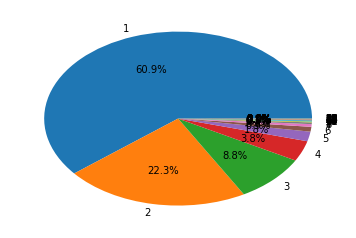

In [651]:
pie_plt = plt.pie(patient_count["ratio"], labels=patient_count.index, autopct='%1.1f%%')

TODO:

Is no show rate independent with the frequency?
what is the percentage of the appointments are made by people who go to clinic more than 2 times

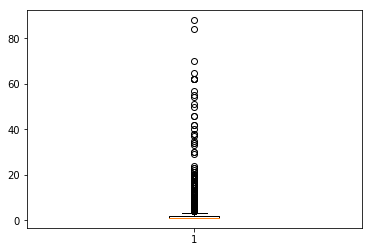

In [652]:
boxplot1 = plt.boxplot(patient["PatientId"])

In [535]:
patient["PatientId"].describe()

count    62298.000000
mean         1.774150
std          1.770336
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: PatientId, dtype: float64

From the table, box plot and five number summary, it is quite clear that most of the people come in once or twice. However, there are quite a few people come in more than two times. I will select the patient ID from those people, and compare their other data.

In [636]:
len(patient[patient["PatientId"] == 1])/len(patient)

0.6086712254004945

Since there are many outliers on the boxplot, I've decided to use histogram to select a good threshold to define "frequent" patient. After choosing frequncy from 1 to 20, 20 looks like a good threshold as the data looks less skewed comparing to previous numbers. The following two histograms are the patient counts being filtered by larger than 19 or 20. When the filter is chosen as 20, the histogram looks significantly less skewed

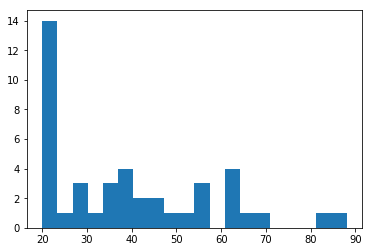

In [653]:
hist_plot_id = plt.hist(patient[patient["PatientId"]> 19]["PatientId"], bins=20)

(array([7., 0., 3., 3., 2., 3., 2., 2., 2., 1., 2., 0., 4., 1., 1., 0., 0.,
        0., 1., 1.]),
 array([21.  , 24.35, 27.7 , 31.05, 34.4 , 37.75, 41.1 , 44.45, 47.8 ,
        51.15, 54.5 , 57.85, 61.2 , 64.55, 67.9 , 71.25, 74.6 , 77.95,
        81.3 , 84.65, 88.  ]),
 <a list of 20 Patch objects>)

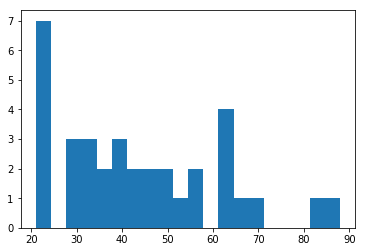

In [600]:
plt.hist(patient[patient["PatientId"]> 20]["PatientId"], bins=20)

{'boxes': [<matplotlib.lines.Line2D at 0x1a303c5470>],
 'caps': [<matplotlib.lines.Line2D at 0x1a303c5e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a303c8b38>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a303c8710>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a303c55c0>,
  <matplotlib.lines.Line2D at 0x1a303c5a58>]}

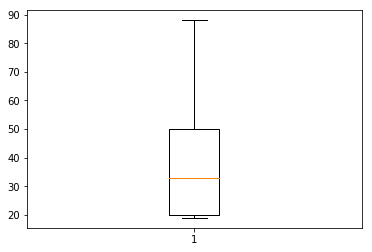

In [626]:
plt.boxplot(patient[patient["PatientId"] > 18]["PatientId"])

In [625]:
patient[patient["PatientId"] > 18]["PatientId"].describe()

count    49.000000
mean     36.836735
std      18.704218
min      19.000000
25%      20.000000
50%      33.000000
75%      50.000000
max      88.000000
Name: PatientId, dtype: float64

In [621]:
len(patient)/3
patient.iloc[3000, :]

PatientId    4
Name: 791478965583917.0, dtype: int64

The boxplot now includes all points within the interquantile range. The average for the patient count is 43.74, and the the standard deviation is 17.94. The standard deviation is still quite large. The first standard deviation will cross the 25 percentile and 75 percentile

### Frequent Customer Checkout

## Age Analysis
To have a closer look at the numercial data, Age and SMS_received, I use describe() to see the summary of the two variables

In [74]:
record[["Age"]].describe()[1:] ## Not showing the Count value, since Count is not important for this dataset

,Age
mean,37.088874
std,23.110205
min,-1.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


In [75]:
age_count = record["Age"].value_counts()
age_count[:9]/len(record)*100

0     3.201933
1     2.056511
52    1.579705
49    1.494657
53    1.493753
56    1.479277
38    1.473848
59    1.469324
2     1.463896
Name: Age, dtype: float64

For all of the appointments, 0-and 1-year old children take 3.2% and 2.1% of the total. Since a patient can visit the clinic more than 1 time, it is expected to have multiple visits from one PatientID. Combining the age into age groups may grasp the larger picture of the age distribution. Also, interestingly, the minimal value for age is -1.

In [202]:
print("The entries with age < 1 is now", str(record[record["Age"] < 0].shape[0]))

The entries with age < 1 is now 0


Since there is no indication of how a lower-than-zero age is documented, age of -1 does not make much sense. I will treat this row as a typo and discard.

In [77]:
record=record[record["Age"] >= 0]

Now, the age range is from 0 to 115. Use a histogram to show the age distribution.

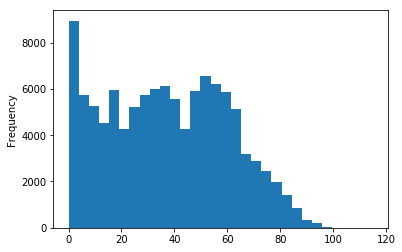

In [78]:
record.index = record["AppointmentID"]
record["Age"].plot.hist(stacked=True, bins=30)

It seems there are a few "bumps" in age distribution. Age groups 0-15, 25-35 and 50-65 have high frequency. It makes sense because new-borns and elderly are prone to diseases. Age groups of 20-23 and 40-43 have the lowest frequency. The drop in 65 years old is not surprising since more people desease as age grows.    

Here comes a question

<strong> Q1. Is no-show rate correlated to age? </strong>

First, let's divide people into 6 age groups of 20 years. ie. 0-19, 20-39, 40-59, 60-79, 80-99, 100-118.

In [79]:
record.loc[:,"Age_Group"] = np.array(np.floor(record.Age/20)+1)

In [80]:
record[["Age","Age_Group"]].head()

,Age,Age_Group
AppointmentID,,
5642903,62,4.0
5642503,56,3.0
5642549,62,4.0
5642828,8,1.0
5642494,56,3.0


In [81]:
factors = np.unique(record["Age_Group"], return_inverse=True)[0].tolist()
factors

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [193]:
## Now let's see the relationship between Age_Group and No Show Rate

no_show_dict = {}
show_dict = {}
for factor in factors:
    no_show_dict[factor] = len(record[(record["Age_Group"] == factor) &(record["No-show"]=="Yes")])
    show_dict[factor] = len(record[(record["Age_Group"] == factor) & (record["No-show"]=="No")])

age_group = ["0-19", "20-39", "40-59", "60-79", "80-99", "100-118"]
df_age_group = pd.DataFrame(data=[no_show_dict,show_dict]).T
df_age_group.rename(columns={0:'No_Show', 1:"Show"}, inplace=True)
df_age_group["No_Show_Rate"] = df_age_group["No_Show"]/(df_age_group["No_Show"]+df_age_group["Show"])
df_age_group["Age_group"] = age_group
df_age_group.round({"No_Show_Rate": 2})



,No_Show,Show,No_Show_Rate,Age_group
1.0,6741,23670,0.22,0-19
2.0,6680,22190,0.23,20-39
3.0,5656,24416,0.19,40-59
4.0,2692,15118,0.15,60-79
5.0,547,2805,0.16,80-99
6.0,3,8,0.27,100-118


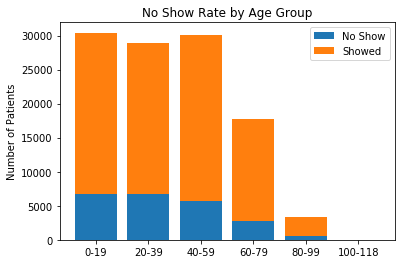

In [83]:
p1 = plt.bar(np.arange(6), df_age_group["No_Show"])
p2 = plt.bar(np.arange(6), df_age_group["Show"], bottom=df_age_group["No_Show"])

plt.title('No Show Rate by Age Group')
plt.ylabel('Number of Patients')
plt.xticks(np.arange(6), ("0-19", "20-39", "40-59", "60-79", "80-99", "100-118"))
plt.legend((p1[0], p2[0]), ('No Show', 'Showed'))

The no show rate slightly correlates to age group as given people in age group 0-19, 20-39, 40-59, 60-79, 80-99, and 100-118, the ratio of people who showed up and people who didn't show up is not the same across all age group. The No Show Rate is about the same for people in age 0-19 and age 20-39. The No Show rate drops after the age hits 40, and continues to remain around 15% until the age grows over 100. Please be noted that the total number of patients in age group 100 and 118 is fairly low (11 people in total). The confidence interval for the no show rate will be expected to be large. <br> <br>

It would be interesting to see the mosaic plot of Age_Group and the No-show Rate

<strong>Mosaic Plot</strong>

OrderedDict([(('4.0', 'No'),
              (0.0, 0.0, 0.15720834695996927, 0.8460288650409172)),
             (('4.0', 'Yes'),
              (0.0,
               0.8493511241771299,
               0.15720834695996927,
               0.15064887582287007)),
             (('3.0', 'No'),
              (0.16208639574045708,
               0.0,
               0.26544466085234114,
               0.809220661111008)),
             (('3.0', 'Yes'),
              (0.16208639574045708,
               0.8125429202472205,
               0.26544466085234114,
               0.18745707975277934)),
             (('1.0', 'No'),
              (0.43240910537328603,
               0.0,
               0.26843700389666625,
               0.7757509495329271)),
             (('1.0', 'Yes'),
              (0.43240910537328603,
               0.7790732086691396,
               0.26843700389666625,
               0.2209267913308602)),
             (('2.0', 'No'),
              (0.7057241580504401,
               0

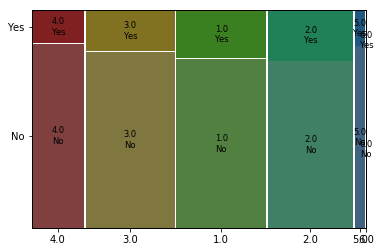

In [160]:
mosaic(record, ["Age_Group", "No-show"])

In [123]:
lookupTable, indexed_dataSet = np.unique(record["No-show"], return_inverse=True)
lookupTable

array(['No', 'Yes'], dtype=object)

In [124]:
indexed_dataSet

array([0, 0, 0, ..., 0, 0, 0])

In [141]:
record["No-show-indexed"] = indexed_dataSet
record[(record["No-show"] == "No") & (record["No-show-indexed"] == 1)].shape

(0, 16)

In [142]:
record[(record["No-show"] == "Yes") & (record["No-show-indexed"] == 0)].shape

(0, 16)

The above two blocks of code indicate that "No" for no-show has been coded as 0, and "Yes" for no-show has been coded as 1.

In [453]:
print("The coefficient of No-show and Age Group is "
      + str(np.corrcoef(record["No-show-indexed"], record["Age_Group"])[0][1].round(4)))
print("The coefficient of No-show and Age is "
      + str(np.corrcoef(record["No-show-indexed"], record["Age"])[0][1].round(4)))

The coefficient of No-show and Age Group is -0.0635
The coefficient of No-show and Age is -0.0603


### Categorical Data

To check the categorical data, I use value_counts() for each of the categorical variables

In [498]:
cols = ["Gender", "Scholarship",
        'Hipertension', "Diabetes", "Neighbourhood",
        "Alcoholism", "Handcap", "SMS_received"]
for col in cols:
    print("Table for " + col + " with " + str(len(record[col].value_counts()))+" categories")
    print(record[col].value_counts()[0:7])
    print("\n")
    

Table for Gender with 2 categories
F    71839
M    38687
Name: Gender, dtype: int64


Table for Scholarship with 2 categories
0    99665
1    10861
Name: Scholarship, dtype: int64


Table for Hipertension with 2 categories
0    88725
1    21801
Name: Hipertension, dtype: int64


Table for Diabetes with 2 categories
0    102583
1      7943
Name: Diabetes, dtype: int64


Table for Neighbourhood with 81 categories
JARDIM CAMBURI     7717
MARIA ORTIZ        5805
RESISTÊNCIA        4431
JARDIM DA PENHA    3877
ITARARÉ            3514
CENTRO             3334
TABUAZEIRO         3132
Name: Neighbourhood, dtype: int64


Table for Alcoholism with 2 categories
0    107166
1      3360
Name: Alcoholism, dtype: int64


Table for Handcap with 5 categories
0    108285
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64


Table for SMS_received with 2 categories
0    75044
1    35482
Name: SMS_received, dtype: int64




It is surprising to see that "Handcap" is not a binary value. According to this [post](https://www.kaggle.com/joniarroba/noshowappointments/discussion/29699), "the handcap refers to the number of desabilites a person has". If a person is both blind and deaf, Handicap for this person will show 2.  

Although I could use almost the same way to determine the no show rate, I'd like to take a closer look at the correlations among variables.

<strong> Q2: What is the correlation between all categorical variables? </strong>

This question can be answered both graphically or mathematically. I'd like to use the mathematical method to discover the correlation to avoid code repetition

In [499]:
cols.extend(["No-show-indexed"])
subdf = record[cols].copy()
subdf.loc[:, "Gender"].replace({"F":0, "M":1}, inplace=True)
subdf.loc[:, "Handcap_or_not"] = subdf.loc[:, "Handcap"].replace({2:1, 3:1, 4:1})
subdf.drop(columns=["Handcap"], inplace=True)
subdf.corr()

,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show-indexed,PatientId,Handcap_or_not
Gender,1.000000,-0.114296,-0.055722,-0.032556,0.106166,-0.046302,-0.004122,0.007898,0.022421
Scholarship,-0.114296,1.000000,-0.019730,-0.024894,0.035022,0.001192,0.029134,-0.002877,-0.009104
Hipertension,-0.055722,-0.019730,1.000000,0.433085,0.087970,-0.006270,-0.035704,-0.006436,0.084851
Diabetes,-0.032556,-0.024894,0.433085,1.000000,0.018473,-0.014552,-0.015181,0.001608,0.059144
Alcoholism,0.106166,0.035022,0.087970,0.018473,1.000000,-0.026149,-0.000197,0.011014,0.003692
SMS_received,-0.046302,0.001192,-0.006270,-0.014552,-0.026149,1.000000,0.126428,-0.009742,-0.025221
No-show-indexed,-0.004122,0.029134,-0.035704,-0.015181,-0.000197,0.126428,1.000000,-0.001456,-0.007281
PatientId,0.007898,-0.002877,-0.006436,0.001608,0.011014,-0.009742,-0.001456,1.000000,-0.008657
Handcap_or_not,0.022421,-0.009104,0.084851,0.059144,0.003692,-0.025221,-0.007281,-0.008657,1.000000


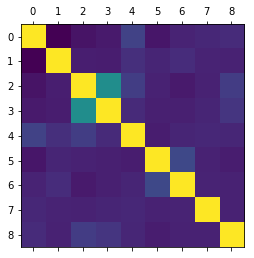

In [500]:
plt.matshow(subdf.corr())

In [285]:
np.corrcoef(record["Diabetes"].tolist(), record["Hipertension"].tolist())

array([[1.        , 0.43308503],
       [0.43308503, 1.        ]])

The correlation coefficient for Hipertension and Diabetes is 0.42, and is much higher than the correlation for any other pairs of variables. To further demonstrate this, I created a mosaic plot.

(<matplotlib.figure.Figure at 0x1a25681f28>,
 OrderedDict([(('No', 'Yes'),
               (0.0, 0.0, 0.9235169717163418, 0.1487977501274958)),
              (('No', 'No'),
               (0.0,
                0.15212000926370842,
                0.9235169717163418,
                0.8478799907362915)),
              (('Yes', 'Yes'),
               (0.9284920960944514,
                0.0,
                0.07150790390554877,
                0.8138551966816724)),
              (('Yes', 'No'),
               (0.9284920960944514,
                0.817177455817885,
                0.07150790390554877,
                0.18282254418211488))]))

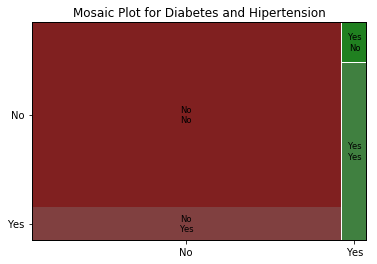

In [288]:
observe_corr = pd.DataFrame(record[["Diabetes", "Hipertension"]]).copy()
observe_corr["Diabetes"].replace({0: "No", 1:"Yes"}, inplace=True)
observe_corr["Hipertension"].replace({0:"No", 1:"Yes"}, inplace=True)
mosaic(observe_corr, ["Diabetes", "Hipertension"], title="Mosaic Plot for Diabetes and Hipertension")

The mosaic plot shows a big difference on the possibiity of Hipertension is Yes given diabete is No, and the possibilty of Hipertension is Yes given diabete is yes, which means Hipertension and Diabete are not independent variables.

#### No-show vs Gender

**Q3: Does gender affect no-show rate?**

**Q4: From the result of no show rate vs gender, what can we conclude from other categorical data?**

Since the correlation table above indicates a low correlation between gender and no-show rate. I guess that gender does not affect no-show rate. In the following code, I will show whether my assumption is correct or not.

(<matplotlib.figure.Figure at 0x1a20509a20>,
 OrderedDict([(('F', 'No'),
               (0.0, 0.0, 0.6467400615221849, 0.7942039459868248)),
              (('F', 'Yes'),
               (0.0,
                0.7975262051230373,
                0.6467400615221849,
                0.20247379487696257)),
              (('M', 'No'),
               (0.6517151859002943,
                0.0,
                0.3482848140997058,
                0.7976616489421403)),
              (('M', 'Yes'),
               (0.6517151859002943,
                0.800983908078353,
                0.3482848140997058,
                0.199016091921647))]))

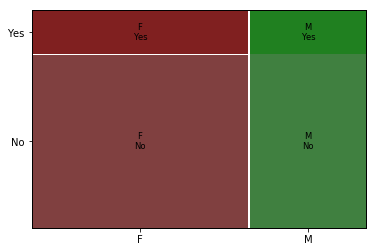

In [178]:
mosaic(record,["Gender", "No-show"])

In [199]:
no_show_dict = {}
show_dict = {}
no_show_dict["F"] = len(record[(record["Gender"] == "F") &(record["No-show"]=="Yes")])
no_show_dict["M"] = len(record[(record["Gender"] == "M") &(record["No-show"]=="Yes")])
show_dict["F"] = len(record[(record["Gender"] == "F") & (record["No-show"]=="No")])
show_dict["M"] = len(record[(record["Gender"] == "M") & (record["No-show"]=="No")])

df_gender_group = pd.DataFrame(data=[no_show_dict,show_dict]).T
df_gender_group.rename(columns={0:'No_Show', 1:"Show"}, inplace=True)
df_gender_group["No_Show_Rate"] = df_gender_group["No_Show"]/(df_gender_group["No_Show"]+df_gender_group["Show"])
df_gender_group

,No_Show,Show,No_Show_Rate
F,14594,57245,0.203149
M,7725,30962,0.199679


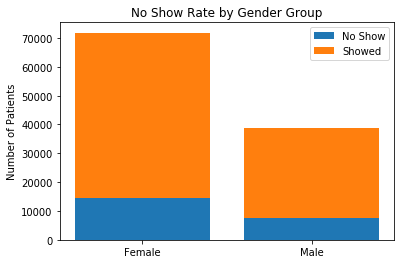

In [215]:
p1 = plt.bar(np.arange(2), df_gender_group["No_Show"])
p2 = plt.bar(np.arange(2), df_gender_group["Show"], bottom=df_gender_group["No_Show"])

plt.title('No Show Rate by Gender Group')
plt.ylabel('Number of Patients')
plt.xticks(np.arange(2), ("Female", "Male"))
plt.legend((p1[0], p2[0]), ('No Show', 'Showed'))

**Conclusion to Q3 and Q4**

From both the table and the mosaic plot, it seems no show rate is gender independent, which means, no matter you are female or male, the difference of no show rate is insignificant, this matches what is given from the correlation table. Therefore, we can safely guess that Hipertension, Diabetes, Alcoholism and Handcap are slightly negatively correlated to no-show. However, the correlation is small. We would expect to see patients with hipertension, diabetes, alcoholism or handcap show up at their appointment a bit more frequent than those who don't have the diseases, but the difference won't be significant.

On the other hand, Scholarship and SMS received are positively correlated to no-show. If one receives a scholarship or receives an SMS message, the patient is less likely to show up to their appointment. The SMS_received shows a slightly higher correlation than other explanatory variables. This contradicts to my instinct, so I will explore this further.

**Q: What is the relationship between SMS_received and No-show?**

(<matplotlib.figure.Figure at 0x1a293af240>,
 OrderedDict([(('0', 'No'),
               (0.0, 0.0, 0.6755934962467578, 0.8301973362781099)),
              (('0', 'Yes'),
               (0.0,
                0.8335195954143224,
                0.6755934962467578,
                0.16648040458567742)),
              (('1', 'No'),
               (0.6805686206248673,
                0.0,
                0.31943137937513283,
                0.7218483903026213)),
              (('1', 'Yes'),
               (0.6805686206248673,
                0.7251706494388338,
                0.31943137937513283,
                0.27482935056116603))]))

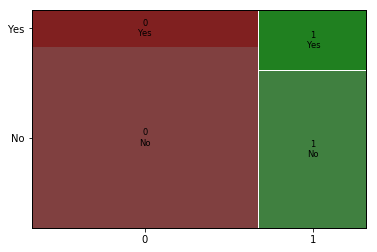

In [459]:
mosaic(record,["SMS_received", "No-show"])

The mosaic plot tells the same thing as we found from the correlation table. It could be the case that there are too few people received the message, so that the no-show rate for people received SMS has a big margin of error.

In [479]:
sms_no_show =record[["SMS_received","No-show"]].copy()
sms_no_show.loc[:,"show"] = sms_no_show["No-show"]
sms_no_show.loc[:,"show"].replace({"Yes": 0, "No":1}, inplace=True)
sms_no_show.loc[:,"No-show"].replace({"Yes": 1, "No":0}, inplace=True)
sms= sms_no_show.groupby(sms_no_show["SMS_received"]).sum()[["No-show", "show"]]
sms.reset_index(inplace=True)
sms["No-show-rate"] = sms["No-show"] /(sms["No-show"] + sms["show"])
sms["Total-people"] = sms["No-show"] + sms["show"]
sms

,SMS_received,No-show,show,No-show-rate,Total-people
0,0,12535,62509,0.167035,75044
1,1,9784,25698,0.275745,35482


Since the sample size is large, we would expect a small range for 95% confidence intervals

**What is the confidence interval for no show rate given SMS-received or not received?**

In [490]:
no_sms = poisson.interval(alpha=0.95, mu=sms.loc[0,"No-show"])/sms.loc[0, "Total-people"]
print ("The upper bound for SMS not received is", str(no_sms[0].round(4)),
      "The lower bound for SMS not receive is", str(no_sms[1].round(4)))

The upper bound for SMS not received is 0.1641 The lower bound for SMS not receive is 0.17


In [491]:
yes_sms = poisson.interval(alpha=0.95, mu=sms.loc[1,"No-show"])/sms.loc[1, "Total-people"]
print ("The upper bound for SMS received is", str(yes_sms[0].round(4)),
      "The lower bound for SMS receive is", str(yes_sms[1].round(4)))

The upper bound for SMS received is 0.2703 The lower bound for SMS receive is 0.2812


**Q4:How is no-show rate distributed from city to city?**

Now, let's create a heatmap for neighbourhood distribution

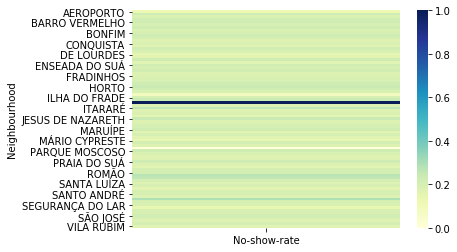

In [396]:
neighbour_no_show =record[["Neighbourhood","No-show"]].copy()
neighbour_no_show.loc[:,"show"] = neighbour_no_show["No-show"]
neighbour_no_show.loc[:,"show"].replace({"Yes": 0, "No":1}, inplace=True)
neighbour_no_show.loc[:,"No-show"].replace({"Yes": 1, "No":0}, inplace=True)
new_df = neighbour_no_show.groupby(neighbour_no_show["Neighbourhood"]).sum()
new_df.loc[:,"total-people"] = new_df["No-show"]+new_df["show"]
new_df.loc[:,"No-show-rate"] = new_df["No-show"]/new_df.loc[:,"total-people"]
heatmap(pd.DataFrame(new_df["No-show-rate"]), cmap="YlGnBu")

According tbo the heatmap, most of the areas have number of people did not show up between 0-250. However, A few areas clearly have higher no-show rate. Let's take a closer look.

In [397]:
new_df.reset_index(inplace=True)

In [398]:
summary_new_df = new_df["No-show-rate"].describe()
summary_new_df

count    81.000000
mean      0.205428
std       0.097230
min       0.000000
25%       0.179907
50%       0.197588
75%       0.217454
max       1.000000
Name: No-show-rate, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x1a255a8630>],
 'caps': [<matplotlib.lines.Line2D at 0x1a2ee91080>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a286246a0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a28d797b8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a255a8860>,
  <matplotlib.lines.Line2D at 0x1a29d318d0>]}

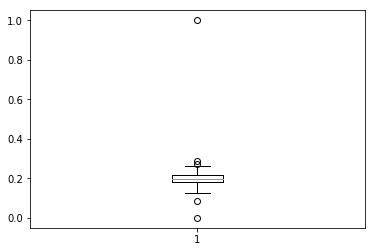

In [399]:
plt.boxplot(new_df["No-show-rate"])

In [455]:
upper_bound = summary_new_df["75%"] + 1.5*(summary_new_df["75%"]-summary_new_df["25%"] )
upper_bound
new_df[new_df["No-show-rate"] > upper_bound]

,Neighbourhood,No-show,show,total-people,No-show-rate
34,ILHAS OCEÂNICAS DE TRINDADE,2,0,2,1.000000
61,SANTA CECÍLIA,123,325,448,0.274554
70,SANTOS DUMONT,369,907,1276,0.289185


The upper "whisker" for the box plot is at 0.27, and the neighbourhood with highest no-show rate is ILHAS OCEÂNICAS DE TRINDADE, however, it has a low study population with total record of 2. We would expect the error for this entry is bigger than the cities with higher study population. Hence, I decided to make a barplot with no-show-rate and 95% confidence interval as error bars.

In [456]:
ten_highest_no_show = new_df[new_df["No-show-rate"] > summary_new_df["75%"]][["Neighbourhood", "No-show-rate", "No-show", "total-people"]].sort_values(by="No-show-rate", ascending=False)[:10]
ten_highest_no_show

,Neighbourhood,No-show-rate,No-show,total-people
34,ILHAS OCEÂNICAS DE TRINDADE,1.000000,2,2
70,SANTOS DUMONT,0.289185,369,1276
61,SANTA CECÍLIA,0.274554,123,448
62,SANTA CLARA,0.264822,134,506
36,ITARARÉ,0.262664,923,3514
40,JESUS DE NAZARETH,0.243954,696,2853
28,HORTO,0.240000,42,175
33,ILHA DO PRÍNCIPE,0.234775,532,2266
9,CARATOÍRA,0.230409,591,2565
1,ANDORINHAS,0.230327,521,2262


In [457]:
get_poisson = lambda x: poisson.interval(alpha=0.95, mu=x)
vfunc = np.vectorize(get_poisson)
ten_highest_no_show["Lower"] = vfunc(ten_highest_no_show["No-show"].tolist())[0]/ten_highest_no_show["total-people"]
ten_highest_no_show["Upper"] = vfunc(ten_highest_no_show["No-show"].tolist())[1]/ten_highest_no_show["total-people"]
ten_highest_no_show

,Neighbourhood,No-show-rate,No-show,total-people,Lower,Upper
34,ILHAS OCEÂNICAS DE TRINDADE,1.000000,2,2,0.000000,2.500000
70,SANTOS DUMONT,0.289185,369,1276,0.260188,0.318966
61,SANTA CECÍLIA,0.274554,123,448,0.227679,0.323661
62,SANTA CLARA,0.264822,134,506,0.221344,0.310277
36,ITARARÉ,0.262664,923,3514,0.245874,0.279738
40,JESUS DE NAZARETH,0.243954,696,2853,0.226078,0.262180
28,HORTO,0.240000,42,175,0.171429,0.314286
33,ILHA DO PRÍNCIPE,0.234775,532,2266,0.214916,0.255075
9,CARATOÍRA,0.230409,591,2565,0.212086,0.249123
1,ANDORINHAS,0.230327,521,2262,0.210875,0.250221


Text(0.5,1,'The highest 10 No Show Rate')

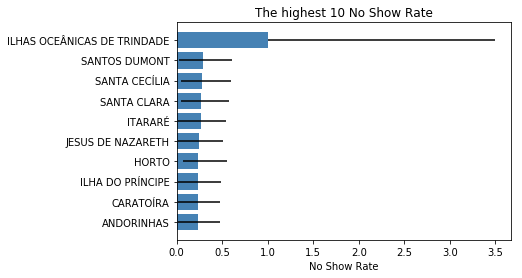

In [458]:
fig, ax = plt.subplots()
error = [ ten_highest_no_show["Lower"], ten_highest_no_show["Upper"],]
y_pos = np.arange(len(ten_highest_no_show))
ax.barh(y_pos, ten_highest_no_show["No-show-rate"], xerr=error,
        color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(ten_highest_no_show["Neighbourhood"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('No Show Rate')
ax.set_title('The highest 10 No Show Rate')

# Patient ID